In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold



# Define the Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, dropout=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128), nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

# Load FashionMNIST
def get_fashionmnist_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    return dataset

# Function to perform subsampling 50% from each class
def subsample_10_percent_per_class(dataset):
    """
    Subsample 10% of the data from each class.
    dataset: The full dataset 
    Returns: A list of indices for the subsampled dataset
    """

    #Get all labels in dataset
    all_labels = np.array([dataset[i][1] for i in range(dataset.data.shape[0])])

    sampled_indices = []
    #Iterate through classes/labels
    for j in range(10):
        #Find indices where label is a certain value
        idx_array = np.where(all_labels == j)[0]
        #Keep 50 percent of these samples, add to sampled_indices list
        random_idxs_class = np.random.randint(0, len(idx_array), size = int(np.round(len(idx_array)/10)))
        sampled_indices.extend(idx_array[random_idxs_class])

    return sampled_indices

# Noam Scheduler (from "Attention is All You Need")
class NoamOpt:
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        self._step += 1
        rate = self.rate()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def zero_grad(self):
        self.optimizer.zero_grad()

    def rate(self, step=None):
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** -0.5) * min(step ** -0.5, step * self.warmup ** -1.5)
    
class CosineAnnealing:
    def __init__(self, max_lr, warmup, total_steps, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.max_lr = max_lr
        self.total_steps = total_steps
        self._rate = 0
    
    def step(self):
        self._step += 1
        rate = self.rate()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def zero_grad(self):
        self.optimizer.zero_grad()

    def rate(self, step=None):
        if step is None:
            step = self._step
        if step <= self.warmup:
            return 1e-4 + (self.max_lr - 1e-4) * (step / self.warmup)
        else:
            return self.max_lr * np.cos((math.pi / 2) * ((step - self.warmup) / (self.total_steps - self.warmup))) + 1e-6

# Train and Validate the Model
def train_and_validate(train_loader, val_loader, model, optimizer, scheduler_type, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)


    if scheduler_type == 'noam':
        scheduler = NoamOpt(model_size=512, factor=30.62, warmup=(len(train_loader)*epochs) // 5, optimizer=optimizer)
    elif scheduler_type == 'cosine':
        scheduler = CosineAnnealing(max_lr = 0.0394, warmup=(len(train_loader)*epochs) // 5, total_steps=len(train_loader)*epochs, optimizer=optimizer)
    else:
        raise ValueError("Unsupported scheduler type.")

    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    global_step = 0   

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            global_step += 1
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            

            scheduler.step() # Step the scheduler
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)
        

        # Validation
        model.eval()
        val_correct, val_total, val_running_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = nn.CrossEntropyLoss()(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss.append(val_running_loss / len(val_loader))
        val_acc.append(100 * val_correct / val_total)
        

    return train_acc, train_loss, val_acc, val_loss

# Cross-validation for hyperparameter tuning
def cross_validate_model(dataset, model_fn, params, k_folds=5, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    kfold = KFold(n_splits=k_folds, shuffle=True)
    results = {}

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Training fold {fold+1}/{k_folds}...")

        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=params['batch_size'], shuffle=False)

        model = model_fn(dropout=params['dropout']).to(device)
        optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=params['momentum'], weight_decay=params['weight_decay'])

        if params['lr_scheduler'] == 'noam':
            train_acc, train_loss, val_acc, val_loss = train_and_validate(train_loader, val_loader, model, optimizer, 'noam', epochs)
        else:
            train_acc, train_loss, val_acc, val_loss = train_and_validate(train_loader, val_loader, model, optimizer, 'cosine', epochs)

        results[fold] = {
            'train_acc': train_acc,
            'train_loss': train_loss,
            'val_acc': val_acc,
            'val_loss': val_loss
        }

    return results

# Grid Search with Batch Size and Other Parameters
def grid_search(dataset, model_fn, param_grid, k_folds=5, epochs=5):
    best_params = None
    best_val_acc = 0

    all_results = {}

    # Iterate through each hyperparameter combination
    for dropout in param_grid['dropout']:
        for momentum in param_grid['momentum']:
            for batch_size in param_grid['batch_size']:
                for weight_decay in param_grid['weight_decay']:
                    for lr_scheduler in param_grid['lr_scheduler']:
                        params = {
                            'dropout': dropout,
                            'momentum': momentum,
                            'batch_size': batch_size,
                            'weight_decay': weight_decay,
                            'lr_scheduler': lr_scheduler
                        }

                        print(f"Evaluating: {params}")

                        results = cross_validate_model(Subset(dataset, subsample_10_percent_per_class(dataset)), model_fn, params, k_folds, epochs)

                        avg_val_acc = np.mean([results[fold]['val_acc'][-1] for fold in range(k_folds)])

                        print(f"Avg Validation Accuracy: {avg_val_acc:.2f}%")

                        if avg_val_acc > best_val_acc:
                            best_val_acc = avg_val_acc
                            best_params = params

                        # Store results for all hyperparameters for plotting later
                        hyperparams_key = f"Dropout: {dropout}, Momentum: {momentum}, Batch Size: {batch_size}, WD: {weight_decay}, LR Scheduler: {lr_scheduler}"
                        all_results[hyperparams_key] = {
                            'val_acc': [np.mean([results[fold]['val_acc'][-1] for fold in range(k_folds)])],
                            'train_acc': [np.mean([results[fold]['train_acc'][-1] for fold in range(k_folds)])],
                            'train_loss': [np.mean([results[fold]['train_loss'][-1] for fold in range(k_folds)])],
                            'val_loss': [np.mean([results[fold]['val_loss'][-1] for fold in range(k_folds)])]
                        }

    print(f"Best Params: {best_params}")
    return best_params, all_results

# Run the Experiment
def run_experiment():
    dataset = get_fashionmnist_data()

    param_grid = {
        'dropout': [0.2, 0.5],
        'momentum': [0.8, 0.9],
        'batch_size': [64, 128],
        'weight_decay': [0.0, 0.001],
        'lr_scheduler': ['noam', 'cosine']
    }

    print("starting grid search")
    best_params, all_results = grid_search(dataset, SimpleCNN, param_grid, k_folds=5, epochs=5)

    print(f"Best Hyperparameters: {best_params}")

    # Plot validation accuracy for each hyperparameter combination
    plt.figure(figsize=(10, 6))
    for key, result in all_results.items():
        plt.plot(result['val_acc'], label=key)
    plt.xlabel('Hyperparameter Combinations')
    plt.ylabel('Validation Accuracy')
    plt.legend()

    return best_params, all_results



starting grid search
Evaluating: {'dropout': 0.2, 'momentum': 0.8, 'batch_size': 64, 'weight_decay': 0.0, 'lr_scheduler': 'noam'}
Training fold 1/5...
Training fold 2/5...
Training fold 3/5...
Training fold 4/5...
Training fold 5/5...
Avg Validation Accuracy: 86.80%
Evaluating: {'dropout': 0.2, 'momentum': 0.8, 'batch_size': 64, 'weight_decay': 0.0, 'lr_scheduler': 'cosine'}
Training fold 1/5...
Training fold 2/5...
Training fold 3/5...
Training fold 4/5...
Training fold 5/5...
Avg Validation Accuracy: 84.62%
Evaluating: {'dropout': 0.2, 'momentum': 0.8, 'batch_size': 64, 'weight_decay': 0.001, 'lr_scheduler': 'noam'}
Training fold 1/5...
Training fold 2/5...
Training fold 3/5...
Training fold 4/5...
Training fold 5/5...
Avg Validation Accuracy: 86.03%
Evaluating: {'dropout': 0.2, 'momentum': 0.8, 'batch_size': 64, 'weight_decay': 0.001, 'lr_scheduler': 'cosine'}
Training fold 1/5...
Training fold 2/5...
Training fold 3/5...
Training fold 4/5...
Training fold 5/5...
Avg Validation Accu

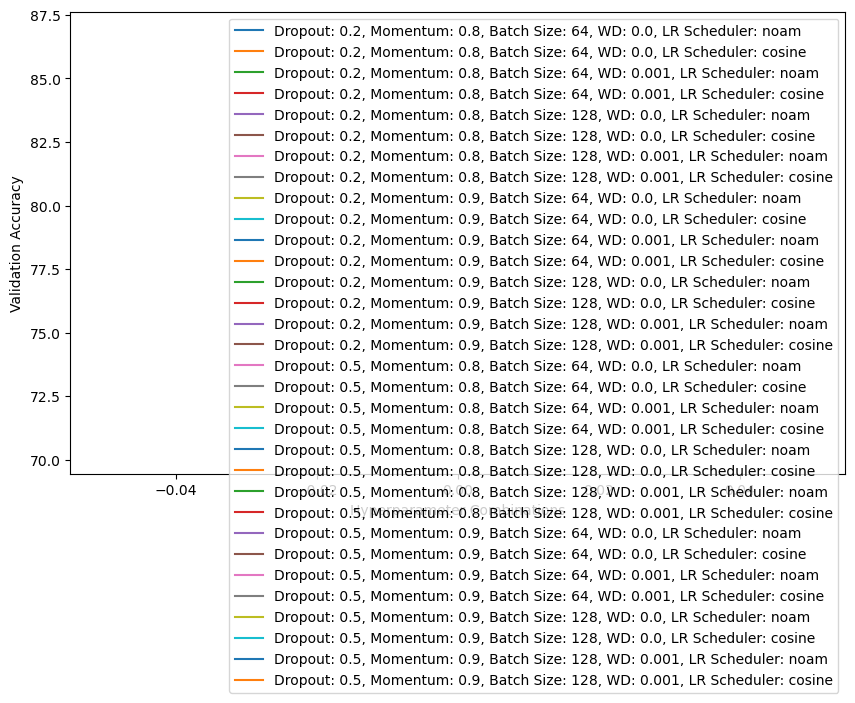

In [5]:
best_params, all_results = run_experiment()


In [6]:
low_dropout_keys, high_dropout_keys = [], []
for momentum in [0.8, 0.9]:
    for batch_size in [64, 128]:
        for weight_decay in [0.0, 0.001]:
            for lr_scheduler in ['noam', 'cosine']:
                low_dropout_keys.append(f"Dropout: {0.2}, Momentum: {momentum}, Batch Size: {batch_size}, WD: {weight_decay}, LR Scheduler: {lr_scheduler}")
                high_dropout_keys.append(f"Dropout: {0.5}, Momentum: {momentum}, Batch Size: {batch_size}, WD: {weight_decay}, LR Scheduler: {lr_scheduler}")

low_momentum_keys, high_momentum_keys = [], []
for dropout in [0.2, 0.5]:
    for batch_size in [64, 128]:
        for weight_decay in [0.0, 0.001]:
            for lr_scheduler in ['noam', 'cosine']:
                low_momentum_keys.append(f"Dropout: {dropout}, Momentum: {0.8}, Batch Size: {batch_size}, WD: {weight_decay}, LR Scheduler: {lr_scheduler}")
                high_momentum_keys.append(f"Dropout: {dropout}, Momentum: {0.9}, Batch Size: {batch_size}, WD: {weight_decay}, LR Scheduler: {lr_scheduler}")

low_bs_keys, high_bs_keys = [], []
for momentum in [0.8, 0.9]:
    for dropout in [0.2, 0.5]:
        for weight_decay in [0.0, 0.001]:
            for lr_scheduler in ['noam', 'cosine']:
                low_bs_keys.append(f"Dropout: {dropout}, Momentum: {momentum}, Batch Size: {64}, WD: {weight_decay}, LR Scheduler: {lr_scheduler}")
                high_bs_keys.append(f"Dropout: {dropout}, Momentum: {momentum}, Batch Size: {128}, WD: {weight_decay}, LR Scheduler: {lr_scheduler}")

low_wd_keys, high_wd_keys = [], []
for momentum in [0.8, 0.9]:
    for batch_size in [64, 128]:
        for dropout in [0.2, 0.5]:
            for lr_scheduler in ['noam', 'cosine']:
                low_wd_keys.append(f"Dropout: {dropout}, Momentum: {momentum}, Batch Size: {batch_size}, WD: {0.0}, LR Scheduler: {lr_scheduler}")
                high_wd_keys.append(f"Dropout: {dropout}, Momentum: {momentum}, Batch Size: {batch_size}, WD: {0.001}, LR Scheduler: {lr_scheduler}")

noam_keys, cosine_keys = [], []
for momentum in [0.8, 0.9]:
    for batch_size in [64, 128]:
        for weight_decay in [0.0, 0.001]:
            for dropout in [0.2, 0.5]:
                noam_keys.append(f"Dropout: {dropout}, Momentum: {momentum}, Batch Size: {batch_size}, WD: {weight_decay}, LR Scheduler: {'noam'}")
                cosine_keys.append(f"Dropout: {dropout}, Momentum: {momentum}, Batch Size: {batch_size}, WD: {weight_decay}, LR Scheduler: {'cosine'}")

In [8]:
low_dropout_keys

['Dropout: 0.2, Momentum: 0.8, Batch Size: 64, WD: 0.0, LR Scheduler: noam',
 'Dropout: 0.2, Momentum: 0.8, Batch Size: 64, WD: 0.0, LR Scheduler: cosine',
 'Dropout: 0.2, Momentum: 0.8, Batch Size: 64, WD: 0.001, LR Scheduler: noam',
 'Dropout: 0.2, Momentum: 0.8, Batch Size: 64, WD: 0.001, LR Scheduler: cosine',
 'Dropout: 0.2, Momentum: 0.8, Batch Size: 128, WD: 0.0, LR Scheduler: noam',
 'Dropout: 0.2, Momentum: 0.8, Batch Size: 128, WD: 0.0, LR Scheduler: cosine',
 'Dropout: 0.2, Momentum: 0.8, Batch Size: 128, WD: 0.001, LR Scheduler: noam',
 'Dropout: 0.2, Momentum: 0.8, Batch Size: 128, WD: 0.001, LR Scheduler: cosine',
 'Dropout: 0.2, Momentum: 0.9, Batch Size: 64, WD: 0.0, LR Scheduler: noam',
 'Dropout: 0.2, Momentum: 0.9, Batch Size: 64, WD: 0.0, LR Scheduler: cosine',
 'Dropout: 0.2, Momentum: 0.9, Batch Size: 64, WD: 0.001, LR Scheduler: noam',
 'Dropout: 0.2, Momentum: 0.9, Batch Size: 64, WD: 0.001, LR Scheduler: cosine',
 'Dropout: 0.2, Momentum: 0.9, Batch Size: 128, 

In [36]:
low_dropout_arr = np.array([[all_results[low_dropout_keys[i]][resultname][0].item() for resultname in ['val_acc', 'train_acc']] for i in range(len(low_dropout_keys))])
high_dropout_arr = np.array([[all_results[high_dropout_keys[i]][resultname][0].item() for resultname in ['val_acc', 'train_acc']] for i in range(len(high_dropout_keys))])

low_momentum_arr = np.array([[all_results[low_momentum_keys[i]][resultname][0].item() for resultname in ['val_acc', 'train_acc']] for i in range(len(low_momentum_keys))])
high_momentum_arr = np.array([[all_results[high_momentum_keys[i]][resultname][0].item() for resultname in ['val_acc', 'train_acc']] for i in range(len(high_momentum_keys))])

low_bs_arr = np.array([[all_results[low_bs_keys[i]][resultname][0].item() for resultname in ['val_acc', 'train_acc']] for i in range(len(low_bs_keys))])
high_bs_arr = np.array([[all_results[high_bs_keys[i]][resultname][0].item() for resultname in ['val_acc', 'train_acc']] for i in range(len(high_bs_keys))])

low_wd_arr = np.array([[all_results[low_wd_keys[i]][resultname][0].item() for resultname in ['val_acc', 'train_acc']] for i in range(len(low_wd_keys))])
high_wd_arr = np.array([[all_results[high_wd_keys[i]][resultname][0].item() for resultname in ['val_acc', 'train_acc']] for i in range(len(high_wd_keys))])

noam_arr = np.array([[all_results[low_dropout_keys[i]][resultname][0].item() for resultname in ['val_acc', 'train_acc']] for i in range(len(noam_keys))])
cosine_arr = np.array([[all_results[high_dropout_keys[i]][resultname][0].item() for resultname in ['val_acc', 'train_acc']] for i in range(len(cosine_keys))])

In [45]:
dropout_arr_mean = np.concat([low_dropout_arr.mean(0), high_dropout_arr.mean(0)]).reshape(2, 2)
dropout_arr_std = np.concat([low_dropout_arr.std(0), high_dropout_arr.std(0)]).reshape(2, 2)

momentum_arr_mean = np.concat([low_momentum_arr.mean(0), high_momentum_arr.mean(0)]).reshape(2, 2)
momentum_arr_std = np.concat([low_momentum_arr.std(0), high_momentum_arr.std(0)]).reshape(2, 2)

bs_arr_mean = np.concat([low_bs_arr.mean(0), high_bs_arr.mean(0)]).reshape(2, 2)
bs_arr_std = np.concat([low_bs_arr.std(0), high_bs_arr.std(0)]).reshape(2, 2)

wd_arr_mean = np.concat([low_wd_arr.mean(0), high_wd_arr.mean(0)]).reshape(2, 2)
wd_arr_std = np.concat([low_wd_arr.std(0), high_wd_arr.std(0)]).reshape(2, 2)

lr_arr_mean = np.concat([noam_arr.mean(0), cosine_arr.mean(0)]).reshape(2, 2)
lr_arr_std = np.concat([noam_arr.std(0), cosine_arr.std(0)]).reshape(2, 2)




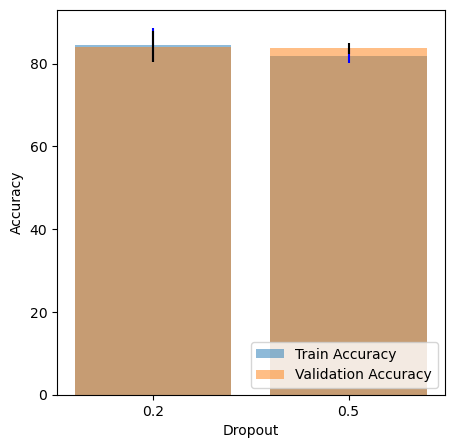

In [64]:
plt.figure(figsize = [5, 5])
plt.bar([1, 2], dropout_arr_mean[:, 1], yerr = dropout_arr_std[:, 1], alpha = 0.5, label = 'Train Accuracy', ecolor = 'b')
plt.bar([1, 2], dropout_arr_mean[:, 0], yerr = dropout_arr_std[:, 0], alpha = 0.5, label = 'Validation Accuracy')
plt.ylabel("Accuracy")
plt.xticks([1 , 2], [0.2, 0.5])
plt.xlabel("Dropout")
plt.legend(loc = 'lower right')

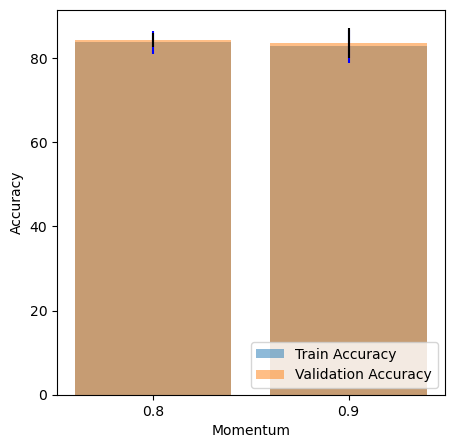

In [63]:
plt.figure(figsize = [5, 5])
plt.bar([1, 2], momentum_arr_mean[:, 1], yerr = momentum_arr_std[:, 1], alpha = 0.5, label = 'Train Accuracy', ecolor = 'b')
plt.bar([1, 2], momentum_arr_mean[:, 0], yerr = momentum_arr_std[:, 0], alpha = 0.5, label = 'Validation Accuracy')
plt.ylabel("Accuracy")
plt.xticks([1 , 2], [0.8, 0.9])
plt.xlabel("Momentum")
plt.legend(loc = 'lower right')

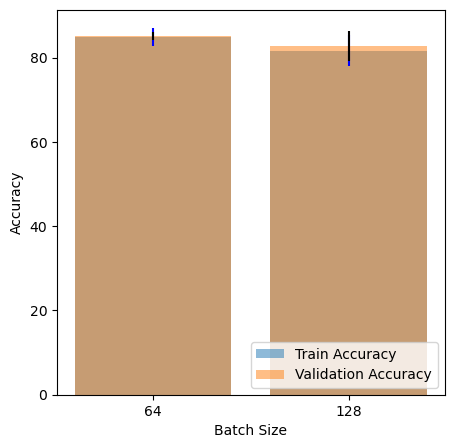

In [65]:
plt.figure(figsize = [5, 5])
plt.bar([1, 2], bs_arr_mean[:, 1], yerr = bs_arr_std[:, 1], alpha = 0.5, label = 'Train Accuracy', ecolor = 'b')
plt.bar([1, 2], bs_arr_mean[:, 0], yerr = bs_arr_std[:, 0], alpha = 0.5, label = 'Validation Accuracy')
plt.ylabel("Accuracy")
plt.xticks([1 , 2], [64, 128])
plt.xlabel("Batch Size")
plt.legend(loc = 'lower right')

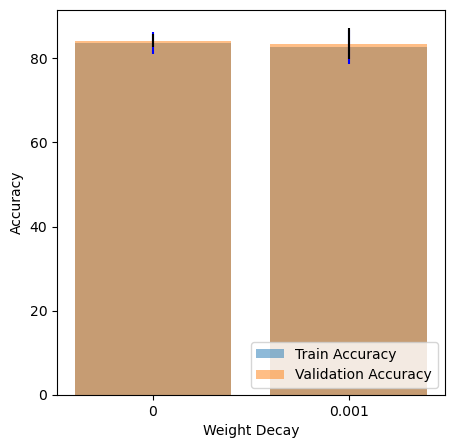

In [66]:
plt.figure(figsize = [5, 5])
plt.bar([1, 2], wd_arr_mean[:, 1], yerr = wd_arr_std[:, 1], alpha = 0.5, label = 'Train Accuracy', ecolor = 'b')
plt.bar([1, 2], wd_arr_mean[:, 0], yerr = wd_arr_std[:, 0], alpha = 0.5, label = 'Validation Accuracy')
plt.ylabel("Accuracy")
plt.xticks([1 , 2], [0, 0.001])
plt.xlabel("Weight Decay")
plt.legend(loc = 'lower right')

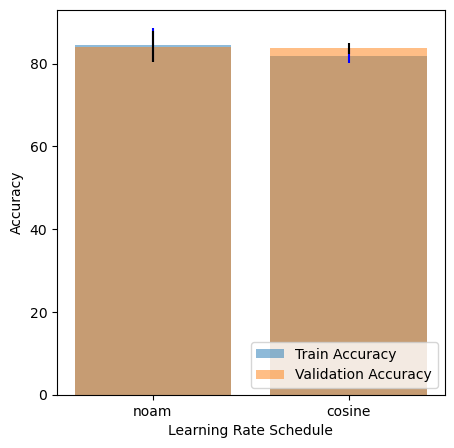

In [67]:
plt.figure(figsize = [5, 5])
plt.bar([1, 2], lr_arr_mean[:, 1], yerr = lr_arr_std[:, 1], alpha = 0.5, label = 'Train Accuracy', ecolor = 'b')
plt.bar([1, 2], lr_arr_mean[:, 0], yerr = lr_arr_std[:, 0], alpha = 0.5, label = 'Validation Accuracy')
plt.ylabel("Accuracy")
plt.xticks([1 , 2], ['noam', 'cosine'])
plt.xlabel("Learning Rate Schedule")
plt.legend(loc = 'lower right')

In [77]:
low_drop_val_acc = all_results[f"Dropout: {0.2}, Momentum: {0.8}, Batch Size: {64}, WD: {0.0}, LR Scheduler: {'noam'}"]['val_acc'][0].item()
low_drop_train_acc = all_results[f"Dropout: {0.2}, Momentum: {0.8}, Batch Size: {64}, WD: {0.0}, LR Scheduler: {'noam'}"]['train_acc'][0].item()
hi_drop_val_acc = all_results[f"Dropout: {0.5}, Momentum: {0.8}, Batch Size: {64}, WD: {0.0}, LR Scheduler: {'noam'}"]['val_acc'][0].item()
hi_drop_train_acc = all_results[f"Dropout: {0.5}, Momentum: {0.8}, Batch Size: {64}, WD: {0.0}, LR Scheduler: {'noam'}"]['train_acc'][0].item()

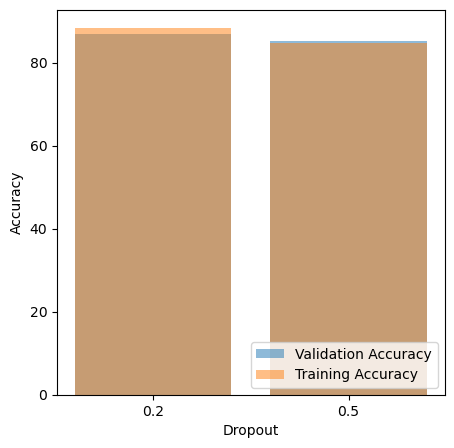

In [78]:
plt.figure(figsize = [5, 5])
plt.bar([1, 2], [low_drop_val_acc, hi_drop_val_acc], alpha = 0.5, label = 'Validation Accuracy')
plt.bar([1, 2], [low_drop_train_acc, hi_drop_train_acc], alpha = 0.5, label = 'Training Accuracy')
plt.ylabel("Accuracy")
plt.xticks([1 , 2], [0.2, 0.5])
plt.xlabel("Dropout")
plt.legend(loc = 'lower right')

In [79]:
low_m_val_acc = all_results[f"Dropout: {0.2}, Momentum: {0.8}, Batch Size: {64}, WD: {0.0}, LR Scheduler: {'noam'}"]['val_acc'][0].item()
low_m_train_acc = all_results[f"Dropout: {0.2}, Momentum: {0.8}, Batch Size: {64}, WD: {0.0}, LR Scheduler: {'noam'}"]['train_acc'][0].item()
hi_m_val_acc = all_results[f"Dropout: {0.2}, Momentum: {0.9}, Batch Size: {64}, WD: {0.0}, LR Scheduler: {'noam'}"]['val_acc'][0].item()
hi_m_train_acc = all_results[f"Dropout: {0.2}, Momentum: {0.9}, Batch Size: {64}, WD: {0.0}, LR Scheduler: {'noam'}"]['train_acc'][0].item()

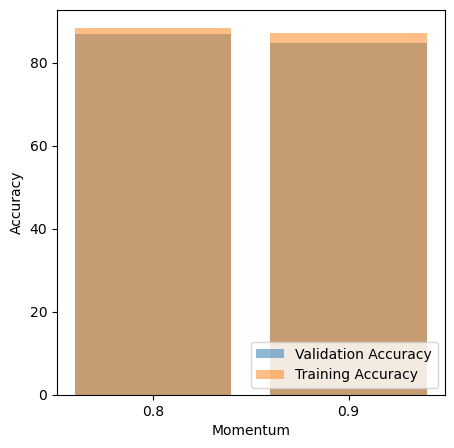

In [80]:
plt.figure(figsize = [5, 5])
plt.bar([1, 2], [low_m_val_acc, hi_m_val_acc], alpha = 0.5, label = 'Validation Accuracy')
plt.bar([1, 2], [low_m_train_acc, hi_m_train_acc], alpha = 0.5, label = 'Training Accuracy')
plt.ylabel("Accuracy")
plt.xticks([1 , 2], [0.8, 0.9])
plt.xlabel("Momentum")
plt.legend(loc = 'lower right')

In [81]:
low_bs_val_acc = all_results[f"Dropout: {0.2}, Momentum: {0.8}, Batch Size: {64}, WD: {0.0}, LR Scheduler: {'noam'}"]['val_acc'][0].item()
low_bs_train_acc = all_results[f"Dropout: {0.2}, Momentum: {0.8}, Batch Size: {64}, WD: {0.0}, LR Scheduler: {'noam'}"]['train_acc'][0].item()
hi_bs_val_acc = all_results[f"Dropout: {0.2}, Momentum: {0.8}, Batch Size: {128}, WD: {0.0}, LR Scheduler: {'noam'}"]['val_acc'][0].item()
hi_bs_train_acc = all_results[f"Dropout: {0.2}, Momentum: {0.8}, Batch Size: {128}, WD: {0.0}, LR Scheduler: {'noam'}"]['train_acc'][0].item()

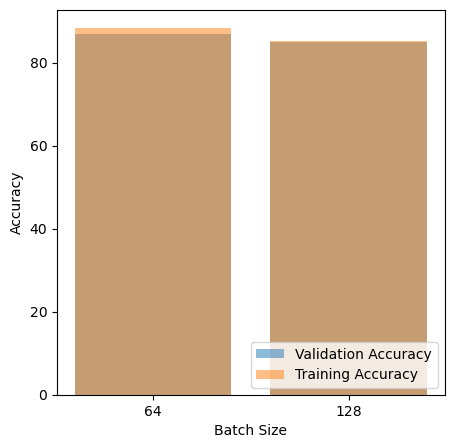

In [82]:
plt.figure(figsize = [5, 5])
plt.bar([1, 2], [low_bs_val_acc, hi_bs_val_acc], alpha = 0.5, label = 'Validation Accuracy')
plt.bar([1, 2], [low_bs_train_acc, hi_bs_train_acc], alpha = 0.5, label = 'Training Accuracy')
plt.ylabel("Accuracy")
plt.xticks([1 , 2], [64, 128])
plt.xlabel("Batch Size")
plt.legend(loc = 'lower right')

In [90]:
low_wd_val_acc = all_results[f"Dropout: {0.2}, Momentum: {0.8}, Batch Size: {64}, WD: {0.0}, LR Scheduler: {'noam'}"]['val_acc'][0].item()
low_wd_train_acc = all_results[f"Dropout: {0.2}, Momentum: {0.8}, Batch Size: {64}, WD: {0.0}, LR Scheduler: {'noam'}"]['train_acc'][0].item()
hi_wd_val_acc = all_results[f"Dropout: {0.2}, Momentum: {0.8}, Batch Size: {64}, WD: {0.001}, LR Scheduler: {'noam'}"]['val_acc'][0].item()
hi_wd_train_acc = all_results[f"Dropout: {0.2}, Momentum: {0.8}, Batch Size: {64}, WD: {0.001}, LR Scheduler: {'noam'}"]['train_acc'][0].item()

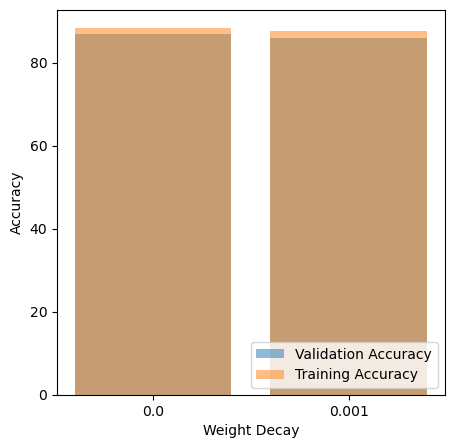

In [91]:
plt.figure(figsize = [5, 5])
plt.bar([1, 2], [low_wd_val_acc, hi_wd_val_acc], alpha = 0.5, label = 'Validation Accuracy')
plt.bar([1, 2], [low_wd_train_acc, hi_wd_train_acc], alpha = 0.5, label = 'Training Accuracy')
plt.ylabel("Accuracy")
plt.xticks([1 , 2], [0.0, 0.001])
plt.xlabel("Weight Decay")
plt.legend(loc = 'lower right')

In [87]:
noam_val_acc = all_results[f"Dropout: {0.2}, Momentum: {0.8}, Batch Size: {64}, WD: {0.0}, LR Scheduler: {'noam'}"]['val_acc'][0].item()
noam_train_acc = all_results[f"Dropout: {0.2}, Momentum: {0.8}, Batch Size: {64}, WD: {0.0}, LR Scheduler: {'noam'}"]['train_acc'][0].item()
cos_val_acc = all_results[f"Dropout: {0.2}, Momentum: {0.8}, Batch Size: {64}, WD: {0.0}, LR Scheduler: {'cosine'}"]['val_acc'][0].item()
cos_train_acc = all_results[f"Dropout: {0.2}, Momentum: {0.8}, Batch Size: {64}, WD: {0.0}, LR Scheduler: {'cosine'}"]['train_acc'][0].item()

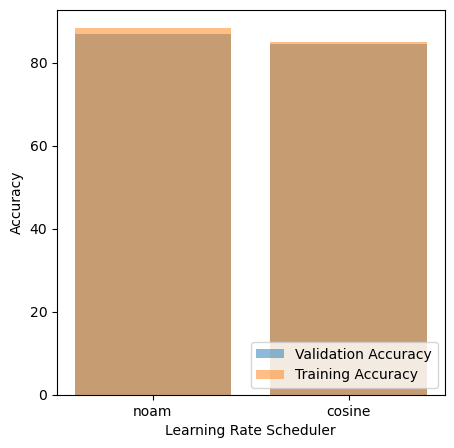

In [88]:
plt.figure(figsize = [5, 5])
plt.bar([1, 2], [noam_val_acc, cos_val_acc], alpha = 0.5, label = 'Validation Accuracy')
plt.bar([1, 2], [noam_train_acc, cos_train_acc], alpha = 0.5, label = 'Training Accuracy')
plt.ylabel("Accuracy")
plt.xticks([1 , 2], ['noam', 'cosine'])
plt.xlabel("Learning Rate Scheduler")
plt.legend(loc = 'lower right')